In [1]:
import huracanpy
# setup
import xarray as xr
import numpy as np
from tqdm import tqdm
from dask.distributed import Client, LocalCluster, progress, as_completed
import glob

# load in pyPI modules
from tcpyPI import pi
#from tcpyPI.utilities import *

import intake
from easygems import healpix as egh

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

import healpy as hp

#my packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load PI data

In [2]:
sim_name = "um_glm_n1280_GAL9"
out_dir = "/work/bb1153/b383007/hk25-hamburg/out_data/"
plot_dir = "/work/bb1153/b383007/hk25-hamburg/out_plots/"
files = glob.glob(out_dir+"*.nc")
dspi = xr.open_mfdataset(files)

# Plot PI fields for single timesteps

In [3]:
out_ds = xr.open_dataset(files[0])
lat, lon = out_ds.lat, out_ds.lon

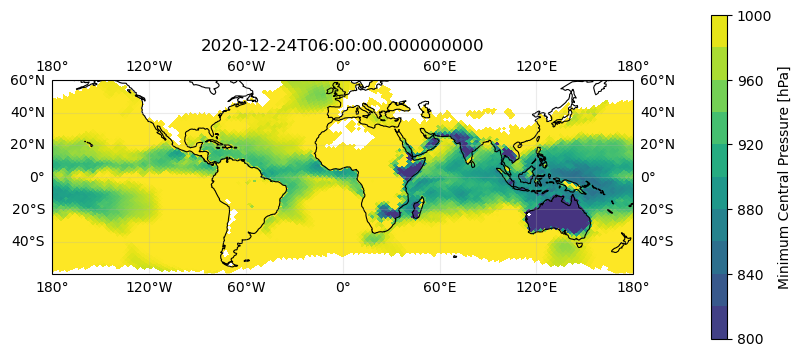

In [21]:
vname="pmin"

def restrict_colormap(cmap, interval, levels):
    cmap_ = plt.get_cmap(cmap)
    colors = cmap_(interval, levels)
    return mcolors.LinearSegmentedColormap.from_list(cmap, colors)

def plot_pi(ds, vname, time, ncolors = 11):
    if vname=="vmax":
        vmin, vmax = 0, 150
    elif vname=="pmin":
        vmin, vmax = 800, 1000
    elif vname=="t0":
        vmin, vmax = 200, 300
    cmap = restrict_colormap('viridis', np.linspace(0.15, 1), ncolors)
    levels = np.linspace(vmin, vmax, ncolors)
    norm=mcolors.Normalize(levels[0], levels[-1])

    var = ds[vname].sel(time=time)
    return vmin, vmax, norm, cmap, levels, var

vmin, vmax, norm, cmap, levels, var = plot_pi(out_ds, vname, out_ds.time[0])

#cmap=plt.get_cmap('viridis', ncolors)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
#ax.set_extent([-65, -5, -10, 25])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
ax.set_title(out_ds.time.values[0])

llat, llon = np.meshgrid(lat, lon)
pc = ax.pcolormesh(llon, llat, var.transpose(), 
                 cmap=cmap, norm=norm)
fig.colorbar(pc, boundaries=levels, label=f"{var.standard_name} [{var.units}]",
             shrink=0.7, pad=0.1)

# Compare PI to tracks

/home/b/b383007/.conda/envs/hk25/lib/python3.12/site-packages/huracanpy/plot/_tracks.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

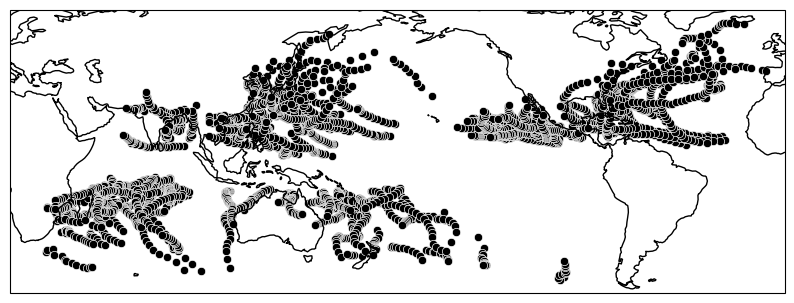

In [5]:
tracks = huracanpy.load(f"../TC_tracks/{sim_name}.csv")
tracks.hrcn.plot_tracks()

In [63]:
dt = np.timedelta64(3, "D") #dt before cyclone passage for PI computation
vname = "vmax"
results = []

track_ids = np.unique(tracks["track_id"].values)

for tid in tqdm(track_ids, desc="Interpolating tracks"):
    # Select track
    tsel = tracks.where(tracks.track_id == tid, drop=True)

    # Shift time
    t_shifted = tsel["time"].values - dt
    t_shifted = np.clip(t_shifted, dspi.time.values[0], dspi.time.values[-1])

    # Bounds check for lat/lon
    in_bounds = (
        (tsel["lat"].values >= dspi.lat.values.min()) & (tsel["lat"].values <= dspi.lat.values.max()) &
        (tsel["lon"].values >= dspi.lon.values.min()) & (tsel["lon"].values <= dspi.lon.values.max())
    )

    if not np.any(in_bounds):
        continue  # skip invalid track

    # Interpolate
    interp = dspi[vname].interp(
        time=xr.DataArray(t_shifted[in_bounds], dims="time"),
        lat=xr.DataArray(tsel["lat"].values[in_bounds], dims="time"),
        lon=xr.DataArray(tsel["lon"].values[in_bounds], dims="time"),
        method="nearest"
    )

    # Package result
    n = interp.sizes["time"]
    results.append(xr.Dataset({
        vname: (["point"], interp.data),
        "track_id": (["point"], [tid] * n),
        "wind_max_925": (["point"], tsel["wind_max_925"].values[in_bounds]),
        "wind_max_850": (["point"], tsel["wind_max_850"].values[in_bounds]),
        "lat": (["point"], tsel["lat"].values[in_bounds]),
        "lon": (["point"], tsel["lon"].values[in_bounds]),
        "time": (["point"], tsel["time"].values[in_bounds]),
        "time_pi": (["point"], t_shifted[in_bounds])
    }))

# Combine
result = xr.concat(results, dim="point")

Interpolating tracks: 100%|██████████| 134/134 [00:09<00:00, 14.58it/s]


In [64]:
def detect_basin(lat, lon):
    """
    Given a latitude and longitude, return a basin name.
    """
    if lon>180:
        lon = lon - 360
    if lat > 0:
        if -100 <= lon <= 0:
            return "NA"  # North Atlantic
        elif -180 <= lon < -100:
            return "EP"  # Eastern Pacific
        elif 100 <= lon <= 180 or -180 <= lon <= -150:
            return "WP"  # Western Pacific
        elif 40 <= lon <= 100:
            return "NI"  # North Indian
    else:
        if 20 <= lon <= 120:
            return "SI"  # South Indian
        elif 120 <= lon <= 200 or -180 <= lon <= -160:
            return "SP"  # South Pacific
        elif -70 <= lon <= 0:
            return "SA"  # South Atlantic
    return "Unknown"

basins = []
for tid in tqdm(track_ids, desc="Getting maxima of umax and PI"):
    mask = result.track_id==tid
    lat0 = result.where(mask, drop=True)["lat"].values[0]
    lon0 = result.where(mask, drop=True)["lon"].values[0]
    basin = detect_basin(lat0, lon0)
    basins.append((tid, basin))
    #print(tid, lat0, lon0, basin)

 # Build mapping
basin_map = {tid: basin for tid, basin in basins}

# Apply to full dataset
basin_array = [basin_map[tid.item()] for tid in result["track_id"].values]
result["basin"] = ("point", basin_array)

Getting maxima of umax and PI: 100%|██████████| 134/134 [00:01<00:00, 74.87it/s]


# Plot comparison of umax with PI for a single track

Text(0.5, 1.0, 'TC 133, Basin: NA')

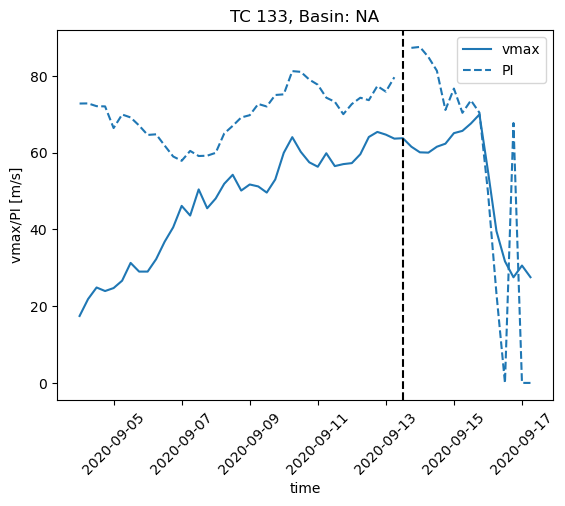

In [65]:
'''plot example'''
'''plotting actual intensity (either at 925 or 850hPa)
and comparing it to its PI dt time (variable defined above) 
before the cyclone passes from this location'''

i = 38
track_ti = track.where(track.time==time_track[i], drop=True)

vname_umax = "wind_max_925"
track_id=66
#track_id = result.track_id[result[vname_umax].argmax().compute()]

mask = result.track_id==track_id
track = result.where(mask, drop=True)
basin = np.unique(track["basin"])[0]
time_track = track["time"]
time_pi = track["time_pi"]
track_umax = track[vname_umax]
track_pi = track["vmax"]

fig, ax = plt.subplots()
ax.plot(time_track, track_umax, color=colors[0], label="vmax")
ax.plot(time_track, track_pi, color=colors[0], ls='--', label="PI")
ax.axvline(track_ti.time, color='k', ls='--')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("time")
ax.set_ylabel(f"vmax/PI [{dspi["vmax"].units}]")#
ax.legend()
ax.set_title(f"TC {tid}, Basin: {basin}")

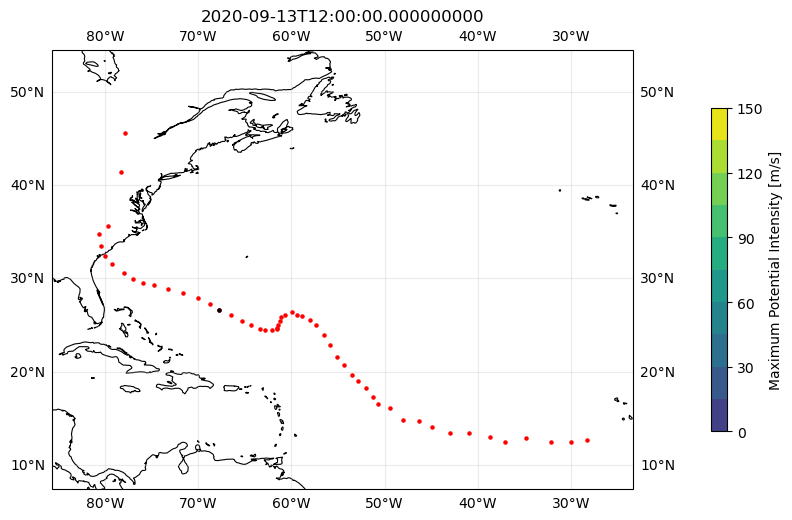

In [66]:
'''plot chosen track with PI at a given timestep'''
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
ax.set_extent([track.lon.min()-5, track.lon.max()+5, 
               track.lat.min()-5, track.lat.max()+5])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)

ax.scatter(track.lon, track.lat, color='r', s=5, zorder=3)
ax.scatter(track_ti.lon, track_ti.lat, color='k', s=5, zorder=3)
ax.set_title(track_ti.time[0].values)

vmin, vmax, norm, cmap, levels, var = plot_pi(dspi, "vmax", 
                                              time_track[i]- dt)

pc = ax.pcolormesh(llon, llat, var.transpose(), cmap=cmap, norm=norm)
fig.colorbar(pc, boundaries=levels, label=f"{var.standard_name} [{var.units}]",
             shrink=0.7, pad=0.1)

# Scatter plot of max(umax) and max(PI)

In [ ]:
vname_umax = "wind_max_925"
track_id=66
#track_id = result.track_id[result[vname_umax].argmax().compute()]

max_umax, max_pi = [], []
for tid in tqdm(track_ids, desc="Getting maxima of umax and PI"):
    mask = result.track_id==tid
    track_umax = result.where(mask, drop=True)[vname_umax]
    track_pi = result.where(mask, drop=True)["vmax"]
    max_umax.append([tid, track_umax.max()])
    max_pi.append([tid, track_pi.max()])

    #detect basin
    lat0 = result.where(mask, drop=True)["lat"].values[0]
    lon0 = result.where(mask, drop=True)["lon"].values[0]
    basin = detect_basin(lat0, lon0)
    basins.append((tid, basin))
    #print(tid, lat0, lon0, basin)

max_umax = np.array(max_umax)
max_pi = np.array(max_pi)

Getting maxima of umax and PI: 100%|██████████| 134/134 [00:04<00:00, 31.98it/s]


In [ ]:
unique_basins = ['WP', 'EP', 'SP', 'NA', 'SA', 'NI', 'SI', 'Unknown']
colors_basin = dict(zip(unique_basins, plt.cm.tab10.colors[:len(unique_basins)]))

fig, ax = plt.subplots(figsize=(7,7))
for basin in tqdm(unique_basins):
    ds_basin = result.where(result.basin == basin, drop=True)
    for tid in np.unique(ds_basin.track_id.values):
        track = ds_basin.where(ds_basin.track_id == tid, drop=True)
        mask = max_umax[:,0]==tid
        ax.scatter(max_umax[mask,1], max_pi[mask,1], 
                   color=colors_basin[basin], alpha=0.6)
#ax.scatter(max_umax, max_pi, color=colors_basin)
ax.set_xlabel(f"vmax [{dspi["vmax"].units}]")
ax.set_ylabel(f"PI [{dspi["vmax"].units}]")

for basin, color in colors_basin.items():
    ax.plot([], [], label=basin, color=color)
ax.legend(title="Basin")
ax.set_title(f"max(u) vs max(PI)\n {sim_name}")

xline = np.linspace(0, 200, 100)
ax.plot(xline, xline, color='k')
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
fig.savefig(plot_dir+f"scatter_umax_pi_{sim_name}.png", 
            bbox_inches='tight', dpi=300)

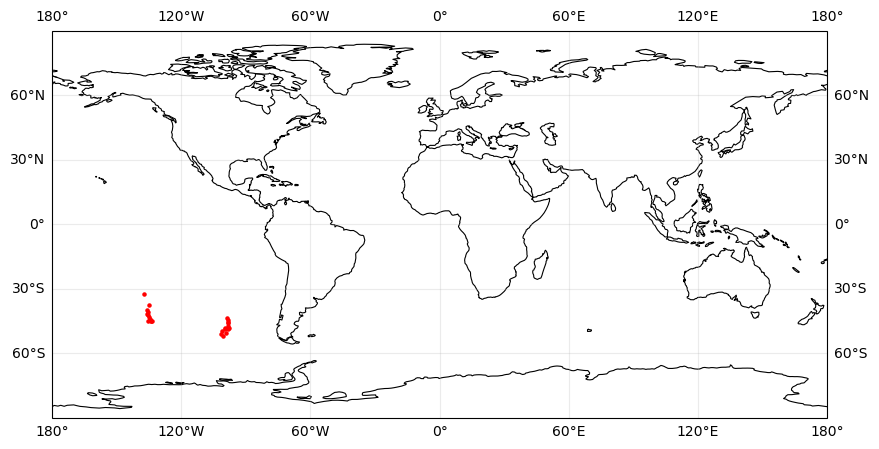

In [41]:
'''plot unknown basin results jic'''
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
ax.set_extent([-180, 180, -90, 90])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
ax.scatter(ds_basin.lon, ds_basin.lat, color='r', s=5)